In [1]:
import json
import os
import numpy
import pandas
import copy
import conntility, connalysis

from scipy.spatial import distance
from pnagm import util, nngraph, instance, test

from matplotlib import pyplot as plt



In [2]:
config_fn = "../configs/characterization_template.json"
plot_out = "plots_1"

with open(config_fn, "r") as fid:
    cfg = json.load(fid)

pts = util.make_points(cfg["make_points"])

if not os.path.exists(plot_out):
    os.makedirs(plot_out)

In [3]:
D = distance.squareform(distance.pdist(pts))
numpy.fill_diagonal(D, numpy.NaN)
mean_nn_dist = numpy.nanmin(D, axis=0).mean()

In [ ]:
with open("../configs/analysis_config.json", "r") as fid:
    analyses = json.load(fid)

def reciprocal_overexpression(m, pts):
    if m.nnz == 0:
        return numpy.nan
    mdl_coo = m.tocoo()
    edge_indices = pandas.DataFrame({"row": mdl_coo.row, "col": mdl_coo.col})
    e_rv = edge_indices.reset_index(drop=True).rename(columns={"row": "col", "col": "row"})[["row", "col"]]
    e = pandas.concat([e_rv, edge_indices.reset_index(drop=True)], axis=0)
    vc = e.drop_duplicates(keep="last").index.value_counts()
    count_rc = (vc == 1).sum()
    count_all = len(edge_indices)
    n_pairs = mdl_coo.shape[0] * (mdl_coo.shape[1] - 1)
    return (count_rc / n_pairs) / ((count_all / n_pairs) ** 2)

analyses["analyses"]["rec_overexpression"] = {
    "source": reciprocal_overexpression,
    "output": "Value"
}

In [6]:
import copy

def generate_parameter_scan_configs(lst_iterations, curr_cfg, curr_dict):
    if len(lst_iterations) == 0:
        return [(curr_dict, curr_cfg)]
    iteration = lst_iterations[0]
    locs = [_iter["loc"] for _iter in iteration["iteration"]]
    vals = [_iter["values"] for _iter in iteration["iteration"]]
    val_tuples = zip(*vals)
    out = []
    for v_tpl in val_tuples:
        cfg = copy.deepcopy(curr_cfg)
        i_dict = curr_dict.copy()
        i_dict[iteration["name"]] = ",".join(list(map(str, v_tpl)))

        for loc, v in zip(locs, v_tpl):
            to_be_set = cfg
            while len(loc) > 1:
                to_be_set = to_be_set[loc[0]]
                loc = loc[1:]
            to_be_set[loc[0]] = v
        out = out + generate_parameter_scan_configs(lst_iterations[1:], cfg, i_dict)
    return out


In [7]:
to_iterate = [
    {
        "name": "neighbor distance",
        "iteration":[
            {
                "loc": ("nngraph", "dist_neighbors"),
                "values": numpy.linspace(1.0, 250.0, 21)
            }
        ]
    },
    {
        "name": "fraction neighbors to pick",
        "iteration":[
            {
                "loc": ("nngraph", "p_pick"),
                "values": numpy.linspace(0.0, 1.0, 21)
            }
        ]
    }
]
cfgs = generate_parameter_scan_configs(to_iterate, cfg, {})

In [8]:
import tqdm

all_res = []
for _params, _cfg in tqdm.tqdm(cfgs):
    mdl_instance, M = util.create_neighbor_spread_graph(pts, _cfg)
    m = conntility.ConnectivityMatrix(mdl_instance,
                                    vertex_properties=pandas.DataFrame(pts, columns=["x", "y", "z"]))
    res = m.analyze(analyses)
    res.update(_params)
    all_res.append(pandas.Series(res))

all_res = pandas.concat(all_res, axis=1).transpose().astype(float)
iter_cols = [_x["name"] for _x in to_iterate]
all_res = all_res.set_index(iter_cols)

all_res["log_cn_bias_aff"] = numpy.log10(all_res["cn_bias_aff"])
all_res["log_cn_bias_eff"] = numpy.log10(all_res["cn_bias_eff"])

100%|██████████| 441/441 [19:27<00:00,  2.65s/it]


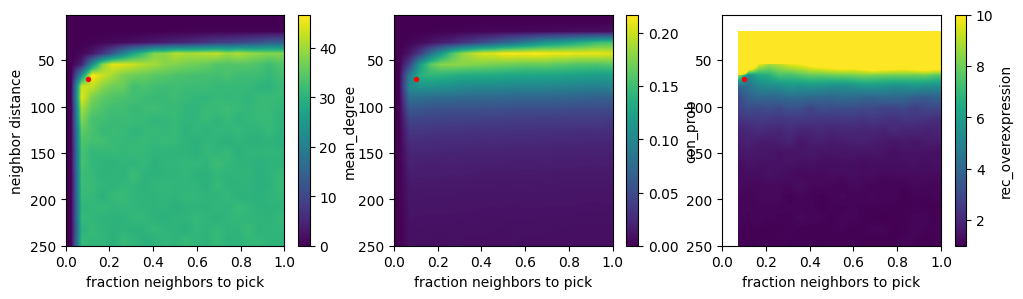

In [9]:
layout = {
    131: "mean_degree",
    132: "con_prob",
    133: ("rec_overexpression", (1, 10))
}
along_x = "fraction neighbors to pick"
along_y = "neighbor distance"
mrk_y = cfg["nngraph"]["dist_neighbors"]
mrk_x = cfg["nngraph"]["p_pick"]

fig = plt.figure(figsize=(12, 3.))

for subplt, prop in layout.items():
    clim = None
    if isinstance(prop, tuple):
        prop, clim = prop
    ax = fig.add_subplot(subplt)
    I = all_res[prop].unstack(along_x)
    iv_x = I.columns.min(), I.columns.max()
    iv_y = I.index.max(), I.index.min()
    img = ax.imshow(I, extent=iv_x + iv_y, aspect="auto", interpolation="bilinear", clim=clim)
    plt.colorbar(img, label=prop)
    ax.set_xlabel(along_x)
    if numpy.mod(subplt, 10) == 1:
        ax.set_ylabel(along_y)
    ax.scatter(mrk_x, mrk_y, c="red", s=8)

fig.savefig(os.path.join(plot_out, "scan_large_1.pdf"))

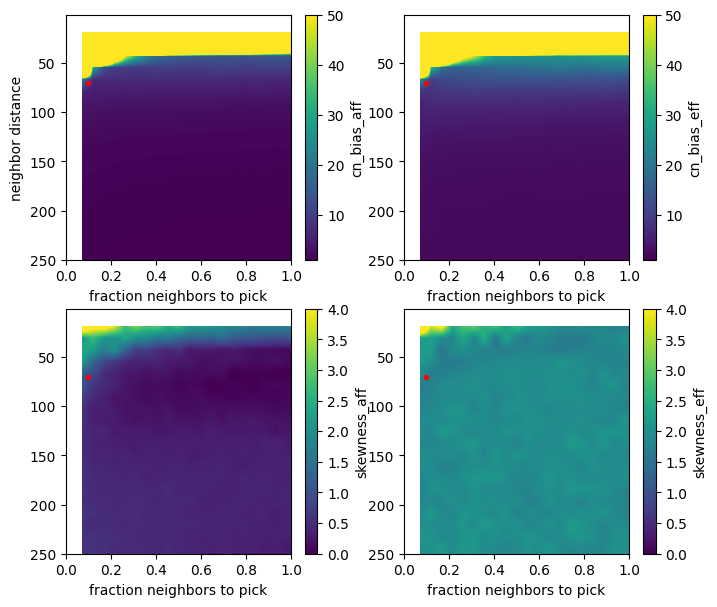

In [10]:
layout = {
    221: ("cn_bias_aff", (1, 50)), 
    222: ("cn_bias_eff", (1, 50)),
    223: ("skewness_aff", (0, 4)),
    224: ("skewness_eff", (0, 4)),
}
along_x = "fraction neighbors to pick"
along_y = "neighbor distance"
mrk_y = cfg["nngraph"]["dist_neighbors"]
mrk_x = cfg["nngraph"]["p_pick"]

fig = plt.figure(figsize=(8, 7.))

for subplt, prop in layout.items():
    clim = None
    if isinstance(prop, tuple):
        prop, clim = prop
    ax = fig.add_subplot(subplt)
    I = all_res[prop].unstack(along_x)
    iv_x = I.columns.min(), I.columns.max()
    iv_y = I.index.max(), I.index.min()
    img = ax.imshow(I, extent=iv_x + iv_y, aspect="auto", interpolation="bilinear", clim=clim)
    plt.colorbar(img, label=prop)
    ax.set_xlabel(along_x)
    if numpy.mod(subplt, 10) == 1:
        ax.set_ylabel(along_y)
    ax.scatter(mrk_x, mrk_y, c="red", s=8)

fig.savefig(os.path.join(plot_out, "scan_large_2.pdf"))

In [11]:
to_iterate = [
    {
        "name": "neighbor distance",
        "iteration":[
            {
                "loc": ("nngraph", "dist_neighbors"),
                "values": numpy.linspace(20.0, 100.0, 21)
            }
        ]
    },
    {
        "name": "fraction neighbors to pick",
        "iteration":[
            {
                "loc": ("nngraph", "p_pick"),
                "values": numpy.linspace(0.05, 0.35, 21)
            }
        ]
    }
]
cfgs = generate_parameter_scan_configs(to_iterate, cfg, {})

In [12]:
import tqdm

all_res = []
for _params, _cfg in tqdm.tqdm(cfgs):
    mdl_instance, M = util.create_neighbor_spread_graph(pts, _cfg)
    m = conntility.ConnectivityMatrix(mdl_instance,
                                    vertex_properties=pandas.DataFrame(pts, columns=["x", "y", "z"]))
    res = m.analyze(analyses)
    res.update(_params)
    all_res.append(pandas.Series(res))

all_res = pandas.concat(all_res, axis=1).transpose().astype(float)
iter_cols = [_x["name"] for _x in to_iterate]
all_res = all_res.set_index(iter_cols)

all_res["log_cn_bias_aff"] = numpy.log10(all_res["cn_bias_aff"])
all_res["log_cn_bias_eff"] = numpy.log10(all_res["cn_bias_eff"])

100%|██████████| 441/441 [13:32<00:00,  1.84s/it]


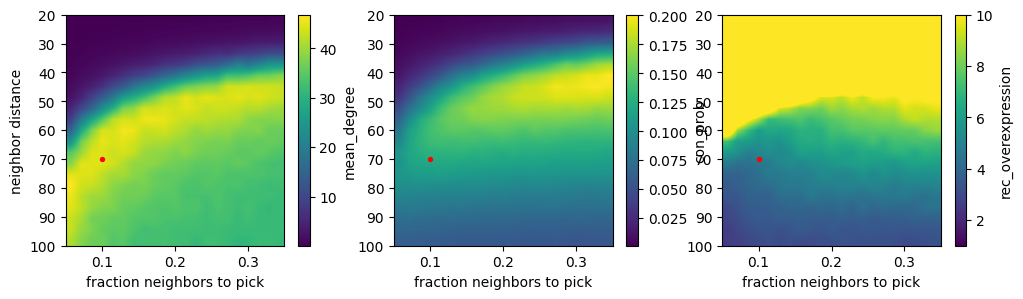

In [13]:
layout = {
    131: "mean_degree",
    132: "con_prob",
    133: ("rec_overexpression", (1, 10))
}
fig = plt.figure(figsize=(12, 3.))

along_x = "fraction neighbors to pick"
along_y = "neighbor distance"

for subplt, prop in layout.items():
    clim = None
    if isinstance(prop, tuple):
        prop, clim = prop
    ax = fig.add_subplot(subplt)
    I = all_res[prop].unstack(along_x)
    iv_x = I.columns.min(), I.columns.max()
    iv_y = I.index.max(), I.index.min()
    img = ax.imshow(I, extent=iv_x + iv_y, aspect="auto", clim=clim, interpolation="bilinear")
    plt.colorbar(img, label=prop)
    ax.set_xlabel(along_x)
    if numpy.mod(subplt, 10) == 1:
        ax.set_ylabel(along_y)
    ax.scatter(mrk_x, mrk_y, c="red", s=8)

fig.savefig(os.path.join(plot_out, "scan_small_1.pdf"))

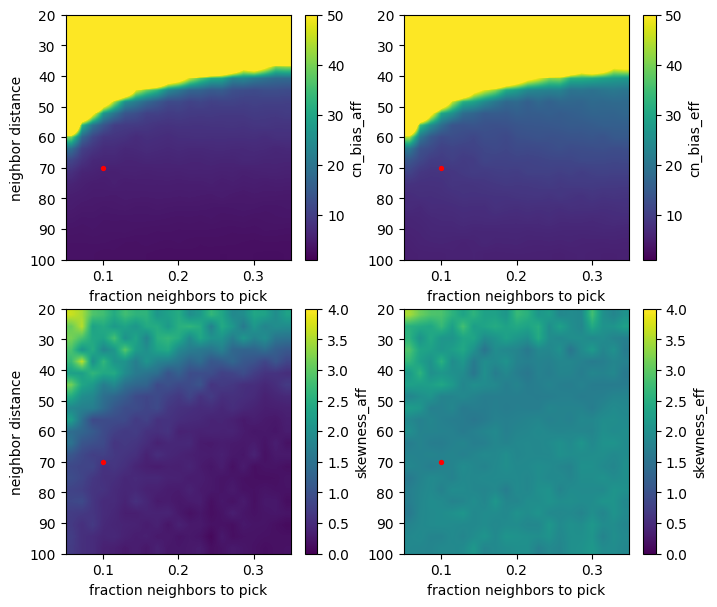

In [14]:
layout = {
    221: ("cn_bias_aff", (1, 50)), 
    222: ("cn_bias_eff", (1, 50)),
    223: ("skewness_aff", (0, 4)),
    224: ("skewness_eff", (0, 4)),
}
along_x = "fraction neighbors to pick"
along_y = "neighbor distance"
mrk_y = cfg["nngraph"]["dist_neighbors"]
mrk_x = cfg["nngraph"]["p_pick"]

fig = plt.figure(figsize=(8, 7.))

for subplt, prop in layout.items():
    clim = None
    if isinstance(prop, tuple):
        prop, clim = prop
    ax = fig.add_subplot(subplt)
    I = all_res[prop].unstack(along_x)
    iv_x = I.columns.min(), I.columns.max()
    iv_y = I.index.max(), I.index.min()
    img = ax.imshow(I, extent=iv_x + iv_y, aspect="auto", interpolation="bilinear", clim=clim)
    plt.colorbar(img, label=prop)
    ax.set_xlabel(along_x)
    if numpy.mod(subplt, 2) == 1:
        ax.set_ylabel(along_y)
    ax.scatter(mrk_x, mrk_y, c="red", s=8)

fig.savefig(os.path.join(plot_out, "scan_small_2.pdf"))

In [15]:
to_iterate = [
    {
        "name": "step target",
        "iteration":[
            {
                "loc": ("instance", "step_tgt"),
                "values": numpy.linspace(0.5, 3.0, 21)
            }
        ]
    },
    {
        "name": "fraction neighbors to pick",
        "iteration":[
            {
                "loc": ("nngraph", "p_pick"),
                "values": numpy.linspace(0.05, 0.35, 21)
            }
        ]
    }
]
cfgs = generate_parameter_scan_configs(to_iterate, cfg, {})


In [16]:
import tqdm

all_res = []
for _params, _cfg in tqdm.tqdm(cfgs):
    mdl_instance, M = util.create_neighbor_spread_graph(pts, _cfg)
    m = conntility.ConnectivityMatrix(mdl_instance,
                                    vertex_properties=pandas.DataFrame(pts, columns=["x", "y", "z"]))
    res = m.analyze(analyses)
    res.update(_params)
    all_res.append(pandas.Series(res))

all_res = pandas.concat(all_res, axis=1).transpose().astype(float)
iter_cols = [_x["name"] for _x in to_iterate]
all_res = all_res.set_index(iter_cols)

all_res["log_cn_bias_aff"] = numpy.log10(all_res["cn_bias_aff"])
all_res["log_cn_bias_eff"] = numpy.log10(all_res["cn_bias_eff"])

100%|██████████| 441/441 [13:04<00:00,  1.78s/it]


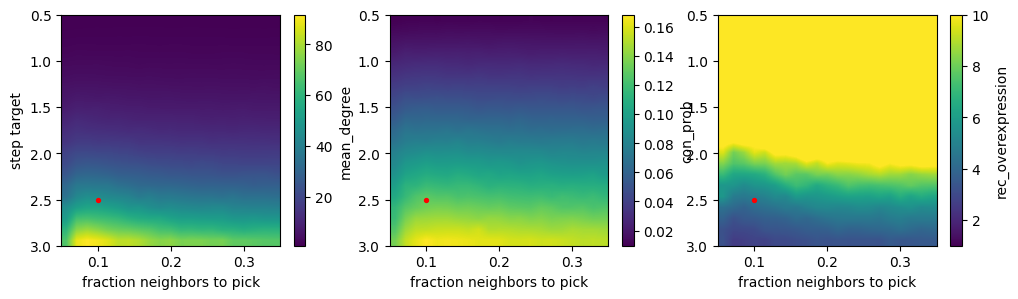

In [17]:
layout = {
    131: "mean_degree",
    132: "con_prob",
    133: ("rec_overexpression", (1, 10))
}
fig = plt.figure(figsize=(12, 3.))

along_x = "fraction neighbors to pick"
along_y = "step target"
mrk_y = cfg["instance"]["step_tgt"]
mrk_x = cfg["nngraph"]["p_pick"]


for subplt, prop in layout.items():
    clim = None
    if isinstance(prop, tuple):
        prop, clim = prop
    ax = fig.add_subplot(subplt)
    I = all_res[prop].unstack(along_x)
    iv_x = I.columns.min(), I.columns.max()
    iv_y = I.index.max(), I.index.min()
    img = ax.imshow(I, extent=iv_x + iv_y, aspect="auto", clim=clim, interpolation="bilinear")
    plt.colorbar(img, label=prop)
    ax.set_xlabel(along_x)
    if numpy.mod(subplt, 10) == 1:
        ax.set_ylabel(along_y)
    ax.scatter(mrk_x, mrk_y, c="red", s=8)

fig.savefig(os.path.join(plot_out, "scan_step_tgt_1.pdf"))

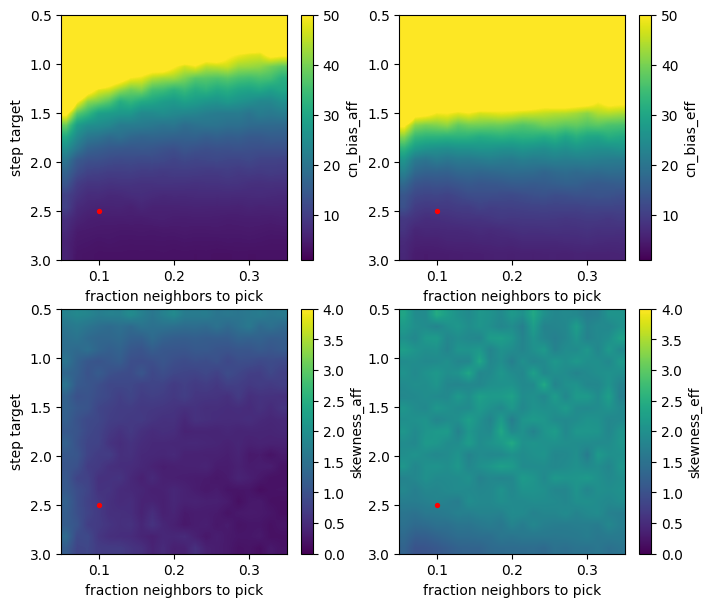

In [18]:
layout = {
    221: ("cn_bias_aff", (1, 50)), 
    222: ("cn_bias_eff", (1, 50)),
    223: ("skewness_aff", (0, 4)),
    224: ("skewness_eff", (0, 4)),
}
along_x = "fraction neighbors to pick"
along_y = "step target"
mrk_y = cfg["instance"]["step_tgt"]
mrk_x = cfg["nngraph"]["p_pick"]

fig = plt.figure(figsize=(8, 7.))

for subplt, prop in layout.items():
    clim = None
    if isinstance(prop, tuple):
        prop, clim = prop
    ax = fig.add_subplot(subplt)
    I = all_res[prop].unstack(along_x)
    iv_x = I.columns.min(), I.columns.max()
    iv_y = I.index.max(), I.index.min()
    img = ax.imshow(I, extent=iv_x + iv_y, aspect="auto", interpolation="bilinear", clim=clim)
    plt.colorbar(img, label=prop)
    ax.set_xlabel(along_x)
    if numpy.mod(subplt, 2) == 1:
        ax.set_ylabel(along_y)
    ax.scatter(mrk_x, mrk_y, c="red", s=8)

fig.savefig(os.path.join(plot_out, "scan_step_tgt_2.pdf"))

In [19]:
mdl_instances = []
for _ in range(25):
    mdl_instance, M = util.create_neighbor_spread_graph(pts, cfg)
    mdl_instances.append(mdl_instance)

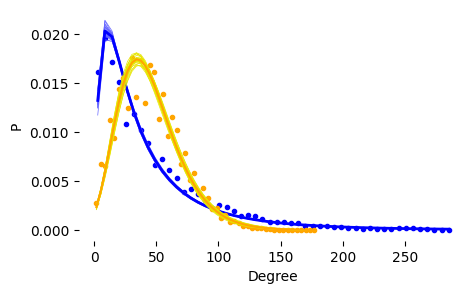

In [20]:
from scipy import stats

def fit_lognorm_to_degrees(degs):
    distr = stats.lognorm(*stats.lognorm.fit(degs.values))
    return distr

fig = plt.figure(figsize=(5, 3))
ax = fig.gca()
outdegs = pandas.concat([
    pandas.Series(_instance.tocoo().row).value_counts()
    for _instance in mdl_instances], axis=0)
indegs = pandas.concat([
    pandas.Series(_instance.tocoo().col).value_counts()
    for _instance in mdl_instances], axis=0)
distr_o = fit_lognorm_to_degrees(outdegs)
distr_i = fit_lognorm_to_degrees(indegs)

idv_distr_o = [fit_lognorm_to_degrees(pandas.Series(_instance.tocoo().row).value_counts())
               for _instance in mdl_instances]
idv_distr_i = [fit_lognorm_to_degrees(pandas.Series(_instance.tocoo().col).value_counts())
               for _instance in mdl_instances]

# Out
outdeg_bins = numpy.linspace(0, outdegs.max() + 1, 51)
outdeg_bin_c = 0.5 * (outdeg_bins[:-1] + outdeg_bins[1:])
outdeg_counts = numpy.histogram(outdegs, bins=outdeg_bins, density=True)[0]

ax.plot(outdeg_bin_c, outdeg_counts, ls="None", marker="o", ms=3, color="blue", label="out, data")
for idv_distr in idv_distr_o:
    ax.plot(outdeg_bin_c, idv_distr.pdf(outdeg_bin_c), color=[0.4, 0.4, 1.0], label=None, lw=0.5)
ax.plot(outdeg_bin_c, distr_o.pdf(outdeg_bin_c), color="blue", label="out, fit",lw=2)

# In
indeg_bins = numpy.linspace(0, indegs.max() + 1, 51)
indeg_bin_c = 0.5 * (indeg_bins[:-1] + indeg_bins[1:])
indeg_counts = numpy.histogram(indegs, bins=indeg_bins, density=True)[0]

ax.plot(indeg_bin_c, indeg_counts, ls="None", marker="o", ms=3, color="orange", label="in, data")
for idv_distr in idv_distr_i:
    ax.plot(indeg_bin_c, idv_distr.pdf(indeg_bin_c), color=[0.9, 0.9, 0.0], label=None, lw=0.5)
ax.plot(indeg_bin_c, distr_i.pdf(indeg_bin_c), color="orange", label="in, fit")

ax.set_xlabel("Degree")
ax.set_ylabel("P")
ax.set_frame_on(False)

fig.savefig(os.path.join(plot_out, "example_degree_dist.pdf"))


In [ ]:
D = distance.squareform(distance.pdist(pts))

def build_cn_info_df(mdl_instance):
    mdl_arr = numpy.array(mdl_instance.todense())
    dbins = [1E-5, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0,
            140.0, 160.0, 180.0, 200.0, 220.0, 240.0, 260.0, 280.0, 300.0]
    dbin_c = 0.5 * (numpy.array(dbins[:-1]) + numpy.array(dbins[1:]))
    Db = numpy.digitize(D, bins=dbins) - 1

    cn_eff = mdl_instance.astype(float) * mdl_instance.astype(float).transpose()
    cn_eff = numpy.array(cn_eff.todense())

    cn_aff = mdl_instance.astype(float).transpose() * mdl_instance.astype(float)
    cn_aff = numpy.array(cn_aff.todense())



    df = pandas.DataFrame({"cn_eff": cn_eff.flatten(), "cn_aff": cn_aff.flatten(),
                           "con": mdl_arr.flatten(), "dbin": Db.flatten()})
    df = df[df["dbin"] >= 0]
    df = df[df["dbin"] < len(dbin_c)]
    df["distance"] = dbin_c[df["dbin"]]
    return df

df = pandas.concat([build_cn_info_df(_instance) for _instance in mdl_instances])
cn_res = df.groupby(["distance", "con"])[["cn_eff", "cn_aff"]].mean().unstack("con")
con_probs = df.groupby("distance")["con"].mean()


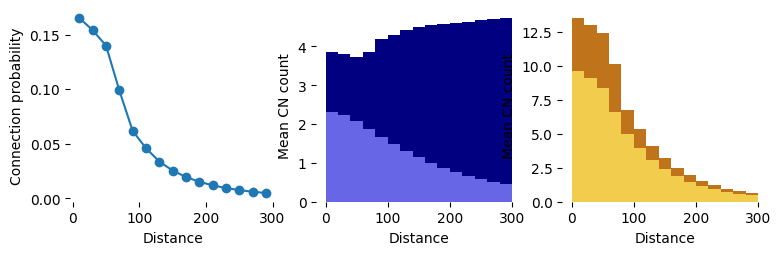

In [22]:
fig = plt.figure(figsize=(9, 2.5))

ax = fig.add_subplot(1, 3, 1)

ax.plot(con_probs, marker='o')
ax.set_xlabel("Distance")
ax.set_ylabel("Connection probability")
ax.set_frame_on(False)

ax = fig.add_subplot(1, 3, 2)

ax.bar(cn_res.index, cn_res[("cn_eff", True)], color=[0.0, 0.0, 0.5], width=20.0)
ax.bar(cn_res.index, cn_res[("cn_eff", False)], color=[0.4, 0.4, 0.9], alpha=1.0, width=20.0)
ax.set_xlabel("Distance")
ax.set_ylabel("Mean CN count")
ax.set_frame_on(False)

ax = fig.add_subplot(1, 3, 3)

ax.bar(cn_res.index, cn_res[("cn_aff", True)], color=[0.75, 0.45, 0.1], width=20.0)
ax.bar(cn_res.index, cn_res[("cn_aff", False)], color=[0.95, 0.8, 0.3], alpha=1.0, width=20.0)
ax.set_xlabel("Distance")
ax.set_ylabel("Mean CN count")
ax.set_frame_on(False)

fig.savefig(os.path.join(plot_out, "example_cn.pdf"))

In [23]:
all_smplx_model = pandas.concat([
    test.DDtest.simplex_counts_and_controls(_instance)
    for _instance in mdl_instances
], axis=1, names=["instance"], keys=range(len(mdl_instances)))

[2025-04-25 20:35:27,851] WARNING: No seed among keyword arguments
[2025-04-25 20:35:28,645] WARNING: No seed among keyword arguments
[2025-04-25 20:35:29,412] WARNING: No seed among keyword arguments
[2025-04-25 20:35:30,194] WARNING: No seed among keyword arguments
[2025-04-25 20:35:30,995] WARNING: No seed among keyword arguments
[2025-04-25 20:35:31,792] WARNING: No seed among keyword arguments
[2025-04-25 20:35:32,568] WARNING: No seed among keyword arguments
[2025-04-25 20:35:33,325] WARNING: No seed among keyword arguments
[2025-04-25 20:35:34,103] WARNING: No seed among keyword arguments
[2025-04-25 20:35:34,898] WARNING: No seed among keyword arguments
[2025-04-25 20:35:35,664] WARNING: No seed among keyword arguments
[2025-04-25 20:35:36,443] WARNING: No seed among keyword arguments
[2025-04-25 20:35:37,221] WARNING: No seed among keyword arguments
[2025-04-25 20:35:37,988] WARNING: No seed among keyword arguments
[2025-04-25 20:35:38,756] WARNING: No seed among keyword argum

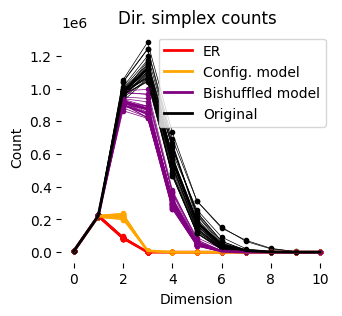

In [24]:
fig = plt.figure(figsize=(3.5, 3))

cols = {"Original": "black", "ER": "red", "Config. model": "orange", "Bishuffled model": "purple"}

ax = fig.gca()
for i in all_smplx_model.columns:
    smplx_model = all_smplx_model[i].unstack(fill_value=0)
    for mdl in smplx_model.index:
        ax.plot(smplx_model.loc[mdl], color=cols[mdl], marker='o', ms=3, lw=0.5)

smplx_model = all_smplx_model.mean(axis=1).unstack(fill_value=0)
for mdl in smplx_model.index:
    ax.plot(smplx_model.loc[mdl], label=mdl, color=cols[mdl], lw=2.0)

ax.set_title("Dir. simplex counts")
ax.set_xlabel("Dimension"); ax.set_ylabel("Count")
ax.set_frame_on(False)
plt.legend()

fig.savefig(os.path.join(plot_out, "example_simplices.pdf"))